# Imagery Preprocessing
I'm going to lay out the steps that were used to preprocess the imagery. First, I'll lay out the steps that were common to both the Lyzenga method and the KNN method. Then, I'll show the steps that were unique to the Lyzenga method.

The Lyzenga method refers to:

> Lyzenga, D.R., Malinas, N.P., Tanis, F.J., 2006. Multispectral bathymetry using a simple physically based algorithm. Geoscience and Remote Sensing, IEEE Transactions on 44, 2251 –2259. doi:10.1109/TGRS.2006.872909


I'll use code from my [OpticalRS](https://github.com/jkibele/OpticalRS) Python library. 

In [2]:
%pylab inline
from OpticalRS import *
from OpticalRS import __version__ as OptRS_version
style.use('ggplot')
print "OpticalRS version: %s" % OptRS_version

Populating the interactive namespace from numpy and matplotlib
OpticalRS version: 0.1.0


In [3]:
cd /home/jkibele/Copy/JobStuff/PhD/iPythonNotebooks/DepthPaper/data

/home/jkibele/Copy/JobStuff/PhD/iPythonNotebooks/DepthPaper/data


## Common to Both Methods
The following steps were common to both the Lyzenga depth estimation and the KNN depth estimation.

### 1. Crop to Multibeam Extent
The WV-2 image was cropped to match this extent of the multibeam derived depth raster. This was done in QGIS. The next lines open the cropped geotiff datasource and retrieve the image array.

In [4]:
imrds = RasterDS('Leigh_DN_clipToMB.tif')
imarr = imrds.band_array

### 2. Mask Land
This step will also eliminate many of the boat and boat wake pixels in the image. For more information on this function see the docsting in the code (execute `print LandMasking.mask_land.__doc__` or [look at the code](https://github.com/jkibele/OpticalRS/blob/develop/OpticalRS/LandMasking.py)).

The same thing can be done with my [Multispectral Land Mask plugin](http://plugins.qgis.org/plugins/landmasker/) for [QGIS](http://qgis.org).

This histogram of the pixel values from the last band of the image (NIR2) shows us where we should set the threshold for land masking. The large peak near 0 is the values from water. The broad low lump from around 400 to 1500 is the land.

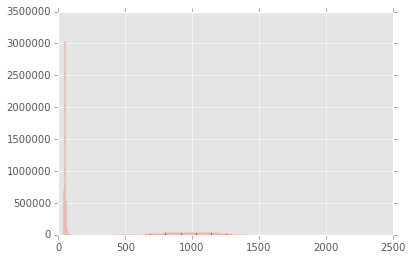

In [5]:
blah = hist( imarr[...,-1].ravel(), 256 )

The next line of code will return a copy of the image array with the land masked. Pixels with values above the `nir_threshold` (set to 100 based on inspecting the histogram) will be masked. Then unmasked pixels that are connected to fewer than `conn_threshold` (set to 2000) will also be masked. The connectivity step is necessary because some pixels on land (generally those in dark shadow or over very low albedo surfaces) will be under the threshold.

In [6]:
masked = LandMasking.mask_land( imarr, nir_threshold=100.0, conn_threshold=2000 )

This will just display one band of the image before and after masking.

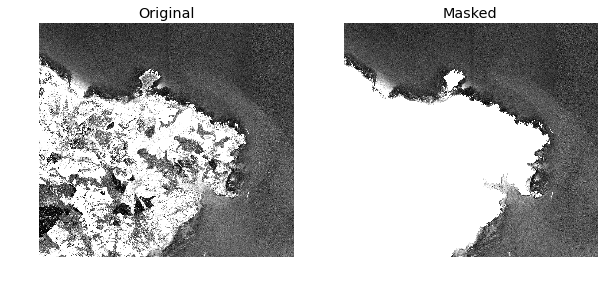

In [7]:
fig,axs = subplots(1,2,figsize=(10,5))
axtitles = ['Original','Masked']
for i,arr in enumerate([imarr,masked]):
    ax = axs[i]
    b = 1
    imclim = np.percentile(masked[...,b].compressed(),1),np.percentile(masked[...,b].compressed(),99)
    ax.imshow( arr[...,b], cmap=plt.cm.gray, clim=imclim )
    ax.set_title( axtitles[i] )
    ax.set_axis_off()

### 3. Denoising
Lyzenga 2006 used a "3x3 contraction" to reduce noise. That method does reduce noise but it also decreases the image resolution (and, therefore, the spatial resolution of the resulting bathymetry) and creates artifacts at the edge of the image (and near masked portions). Bilateral filtering will also reduce noise in the image but it maintains the full spatial resolution, preserves edges better, and produces much smaller artifacts.

Bilateral filtering is described in (Tomasi and Manduchi, 1998) and implemented as [`denoise_bilateral`](http://scikit-image.org/docs/0.11.x/api/skimage.restoration.html#denoise-bilateral) in the [scikit-image](http://scikit-image.org/) Python library. Here, I will apply the bilateral filter to each band of the image as if it were grayscale because the color version only works on images that can be converted to the CIELAB color space.

> Tomasi, C., Manduchi, R., 1998. Bilateral filtering for gray and color images, in: Computer Vision, 1998. Sixth International Conference on. IEEE, pp. 839–846.


In [8]:
from skimage.restoration import denoise_bilateral
from skimage import __version__ as skim_version
print "scikit-image version: %s" % skim_version

scikit-image version: 0.11.3


The `denoise_bilateral` applies `img_as_float` if it gets a non-float image. `img_as_float` doesn't work properly with masked arrays so I'll convert it myself with my `rescale` function from `OpticalRS`.

In [9]:
imrs = ArrayUtils.rescale(masked)

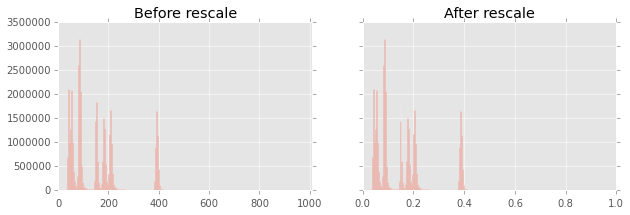

In [11]:
arr = masked[:,:,:]
rsarr = imrs[:,:,:]
fig, (ax1,ax2) = subplots(1,2,sharey=True,figsize=(10,3))
ax1.set_title( "Before rescale" )
ax1.set_xlim( masked.min(), masked.max() )
ax2.set_xlim( imrs.min(), imrs.max() )
ax2.set_title( "After rescale")
blah = ax1.hist( arr.compressed(), 255 )
blah = ax2.hist( rsarr.compressed(), 255 )

In [12]:
imrs.set_fill_value(0.0)

In [13]:
imdenoise = ArrayUtils.each_band( imrs.filled(), denoise_bilateral )

In [14]:
imdenoise = np.ma.masked_where( imrs.mask, imdenoise )

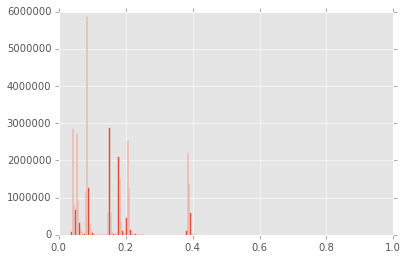

In [15]:
blah = hist( imdenoise.compressed(),256 )

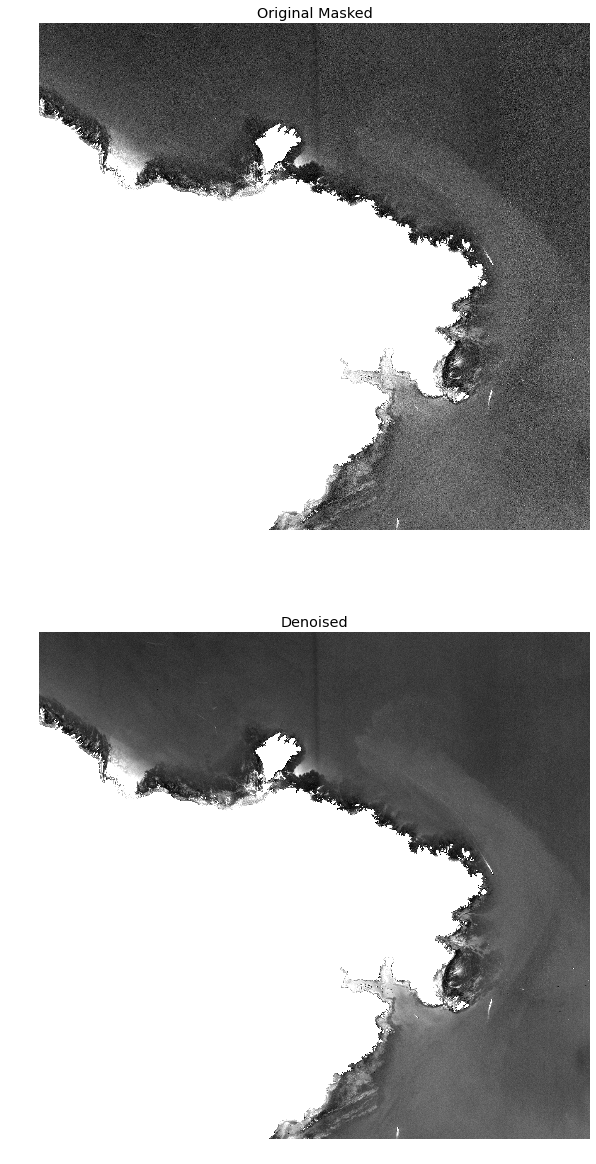

In [16]:
fig,axs = subplots(2,1,figsize=(10,20))
axtitles = ['Original Masked','Denoised']
for i,arr in enumerate([imrs,imdenoise]):
    ax = axs[i]
    b = 1
    imclim = np.percentile(imrs[...,b].compressed(),1),np.percentile(imrs[...,b].compressed(),99)
    ax.imshow( arr[...,b], cmap=plt.cm.gray, clim=imclim )
    ax.set_title( axtitles[i] )
    ax.set_axis_off()

Aside from adjusting the image mask to match the depth data, this is the last preprocessing step needed for the KNN Depth Regression method so I'll save out these results before I carry on with the remaining steps needed for the Lyzenga method.

The line that saves the file is commented out so I don't keep overwriting my data everytime I run this notebook.

In [31]:
# imrds.new_image_from_array(imdenoise.astype('float32'),\
#                            'Leigh_wv2_denoised.tif',dtype=GDT_Float32)

## Lyzenga Preprocessing
The following steps are not needed for the KNN method.

From section V of Lyzenga 2006:

> "Prior  to  the  depth  estimation,  several  preprocessing  steps
were  applied  to the data.  First, the  data  were radiometrically
calibrated to entrance aperture spectral radiance (EASR) using
coefficients provided by Space Imaging [12]. Second, a 3×3
contraction of the images was done to reduce noise while main-
taining an acceptable spatial resolution. Third, the images were
segmented into three categories: 1) land/clouds; 2) deep water;
and 3) shallow water, as described below. Fourth, the sun-glint
correction described in Section III was applied, and finally, the
mean radiance was estimated over optically deep water."

So, as a list:

1. Radiometric calibration to EASR. This is how the DigitalGlobe "Standard Imagery" products are delivered.
2. "3x3 contraction". As previously explained, I'm using bilateral filtering instead and that was done above.
3. Segmenting in this way is not necessary. I'm using the multibeam to select shallow (<20m) water, land/cloud has been masked already (in a way very similar to what Lyzenga did), and, when Lyzenga's shallow water selection method is applied to my data it labels shallow areas with kelp as being deep water. So, the only part of this that's still needed is the identification of deep water areas so I can get the mean and standard deviation from those areas.
4. Sunglint addressed below.
5. Averaging the deep water addressed below.

### Sun Glint Removal

For details about this sunglint removal method, see Lyzenga et al. 2006.

To make use of this method, we need a patch of optically deep water with some sun glint on the surface. There's not much sun glint in my image but the square displayed below has a bit so that's what I used.

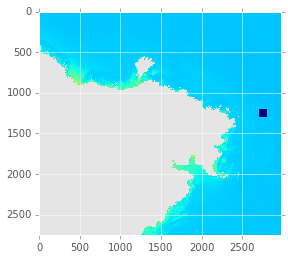

In [40]:
glintind = np.s_[1200:1300,2700:2800,:]
glintarr = imdenoise[glintind]
glintshow = imdenoise.copy()
glintshow[glintind] = 0.0
imshow( glintshow[...,2] )

The next line returns a glint corrected copy of the image array. See the method's docstring for more information.

In [41]:
glntcor = Lyzenga2006.glint_correct_image( imdenoise, glintarr )

In [47]:
# imrds.new_image_from_array(glntcor.astype('float32'),'glint_corrected.tif')

### Dark Pixel Values
I'll need these values to calculate transformed radiance $X_i$. See the method's docstring for more information.

In [49]:
dparr = Lyzenga2006.dark_pixel_array(glntcor)

In [56]:
darkmeans = dparr.reshape(-1,8).mean(0).data
darkstds = dparr.reshape(-1,8).std(0).data

In [58]:
# darkmeans.dump('darkmeans.pkl')
# darkstds.dump('darkstds.pkl')